In [1]:
import tensorflow as tf
from helper_functions import *
from u_net_architectures.base_u_net_architecture import create_base_unet
from u_net_architectures.residual_unet import create_residual_unet
from u_net_architectures.unetpp import create_unet_pp
from u_net_architectures.attention_unet import create_attention_unet
from u_net_architectures.dense_unet import create_dense_unet


import os
from tqdm import tqdm
from glob import glob

from sklearn.model_selection import train_test_split

use_GPU()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Plotting random images with their masks

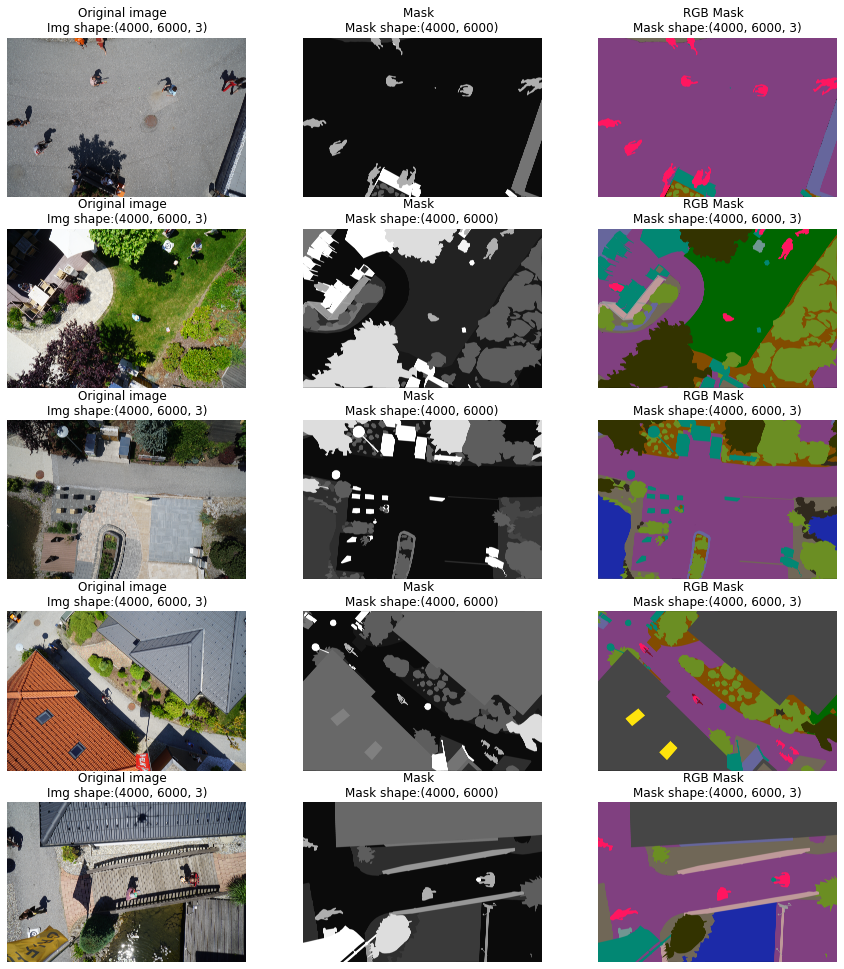

In [4]:
img_path = '../data/dataset/semantic_drone_dataset/original_images'
masks_path = '../data/dataset/semantic_drone_dataset/label_images_semantic'
RGB_masks_path = '../data/RGB_color_image_masks/RGB_color_image_masks'


plot_random_image_segm(images_path=img_path,masks_path=masks_path,RGB_masks_path=RGB_masks_path,no_of_images=5)


In [5]:
augment = False

## Data Augmentation

In [6]:

path = "../data/dataset/semantic-drone-dataset/"
images = sorted(glob(img_path + '/*'))
masks = sorted(glob(masks_path + '/*'))
print(f"Original images:  {len(images)} - Original masks: {len(masks)}")

create_dir('../data/dataset/augmented_data/images/')
create_dir('../data/dataset/augmented_data/masks/')
save_path = '../data/dataset/augmented_data/'

if augment:
    augment_data(images,masks,save_path=save_path,augment=True)

save_path = '../data/dataset/augmented_data/'

images = sorted(glob(save_path + 'images/*'))
masks = sorted(glob(save_path + 'masks/*'))

print(f"Augmented images:  {len(images)} - Augmented masks: {len(masks)}")

image_path =  os.path.join(save_path, "images/")
label_path = os.path.join(save_path, "masks/")

df_images = create_dataframe(image_path)
df_masks = create_dataframe(label_path)
print('Total Images: ', len(df_images))

Original images:  400 - Original masks: 400
Augmented images:  1600 - Augmented masks: 1600
Total Images:  1600


In [7]:
X_trainval, X_test = train_test_split(df_images['id'], test_size=0.1, random_state=19)
X_trainval=df_images['id']
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

Train Size : 1280 images
Val Size   :  320 images
Test Size  :  160 images


In [8]:
y_train = X_train #the same values for images (X) and labels (y)
y_test = X_test
y_val = X_val

img_train = [os.path.join(image_path, f"{name}.jpg") for name in X_train]
mask_train = [os.path.join(label_path, f"{name}.png") for name in y_train]

img_val = [os.path.join(image_path, f"{name}.jpg") for name in X_val]
mask_val = [os.path.join(label_path, f"{name}.png") for name in y_val]

img_test = [os.path.join(image_path, f"{name}.jpg") for name in X_test]
mask_test = [os.path.join(label_path, f"{name}.png") for name in y_test]

## Import and instantiate model

In [27]:
classes = ['tree', 'gras', 'other' 'vegetation', 'dirt', 'gravel', 'rocks', 'water', 'paved area', 'pool', 'person', 'dog', 'car', 'bicycle', 'roof', 'wall', 'fence', 'fence-pole', 'window', 'door', 'obstacle']
classes_ints = [i for i in range(23)]

W=216
H=216
num_classes = 23

# model = create_base_unet((H,W),23,model_name='base_unet')
# model = create_residual_unet((H,W),23,model_name='residual_unet')
# model = create_attention_unet(input_size=(H,W,3),n_labels=23, model_name='attention_unet')
model = create_unet_pp(input_size=(H,W,3),n_labels=23, model_name='unet_plus_plus')

# model = create_dense_unet(input_size=(H,W,3),n_labels=23, model_name='dense_unet')

# model = tf.keras.models.load_model('model_checkpoints/attention_unet.h5')
# model = tf.keras.models.load_model('model_checkpoints/residual_unet.h5')

model.compile(optimizer='adam',
        loss ='categorical_crossentropy', 
        metrics=[tf.keras.metrics.IoU(num_classes=23, target_class_ids=classes_ints, name='IoU'),
                 tf.keras.metrics.CategoricalAccuracy(name='Cat Accuracy')])
model.summary()

Model: "unet_plus_plus"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 216, 216, 3)]     0         
                                                                 
 xnet_down0_0 (Conv2D)       (None, 216, 216, 32)      896       
                                                                 
 xnet_down0_0_activation (Re  (None, 216, 216, 32)     0         
 LU)                                                             
                                                                 
 xnet_down0_1 (Conv2D)       (None, 216, 216, 32)      9248      
                                                                 
 xnet_down0_1_activation (Re  (None, 216, 216, 32)     0         
 LU)                                                             
                                                                 
 xnet_down1_encode_maxpool (  (None, 108, 108, 32)  

In [15]:
# Callbacks

callbacks = [
            tf.keras.callbacks.ModelCheckpoint(filepath=f'model_checkpoints/{model.name}.h5',save_best_only=True),
            tf.keras.callbacks.EarlyStopping(patience=10,verbose=2),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=2, min_lr=1e-6)
            ]


In [16]:

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset
    

def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, num_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask

## Fitting the data and training the model

In [17]:
batch_size = 1

train_data = tf_dataset(img_train,mask_train,batch=batch_size)
validation_data = tf_dataset(img_val,mask_val,batch=batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size


# results = model.fit(train_data,
#                     steps_per_epoch = train_steps,
#                     validation_data = validation_data,
#                     validation_steps = valid_steps, 
#                     epochs=100,
#                     callbacks = callbacks)

## Model validation

In [18]:
test_data = tf_dataset(img_test,mask_test,batch=batch_size)
test_steps = len(img_test)//batch_size
# model.evaluate(test_data,steps=test_steps)

In [20]:
for checkpoints in os.listdir('model_checkpoints/'):
    print(checkpoints[:-2])
    model = tf.keras.models.load_model(f'model_checkpoints/{checkpoints}')
    model.evaluate(test_data,steps=test_steps)
    

base_unet.
160/160 [==============================] - 13s 52ms/step - loss: 1.1917 - IoU: 0.4783 - Cat Accuracy: 0.6669
residual_unet.
160/160 [==============================] - 9s 47ms/step - loss: 1.4893 - IoU: 0.4783 - Cat Accuracy: 0.5549
attention_unet.
160/160 [==============================] - 7s 36ms/step - loss: 0.5810 - IoU: 0.4968 - Cat Accuracy: 0.8322
unet_plus_plus.
160/160 [==============================] - 6s 36ms/step - loss: 0.6140 - IoU: 0.4783 - Cat Accuracy: 0.8276
dense_unet.
160/160 [==============================] - 10s 52ms/step - loss: 1.2734 - IoU: 0.4783 - Cat Accuracy: 0.6079


# Predictions

100%|██████████| 160/160 [00:00<00:00, 165864.72it/s]


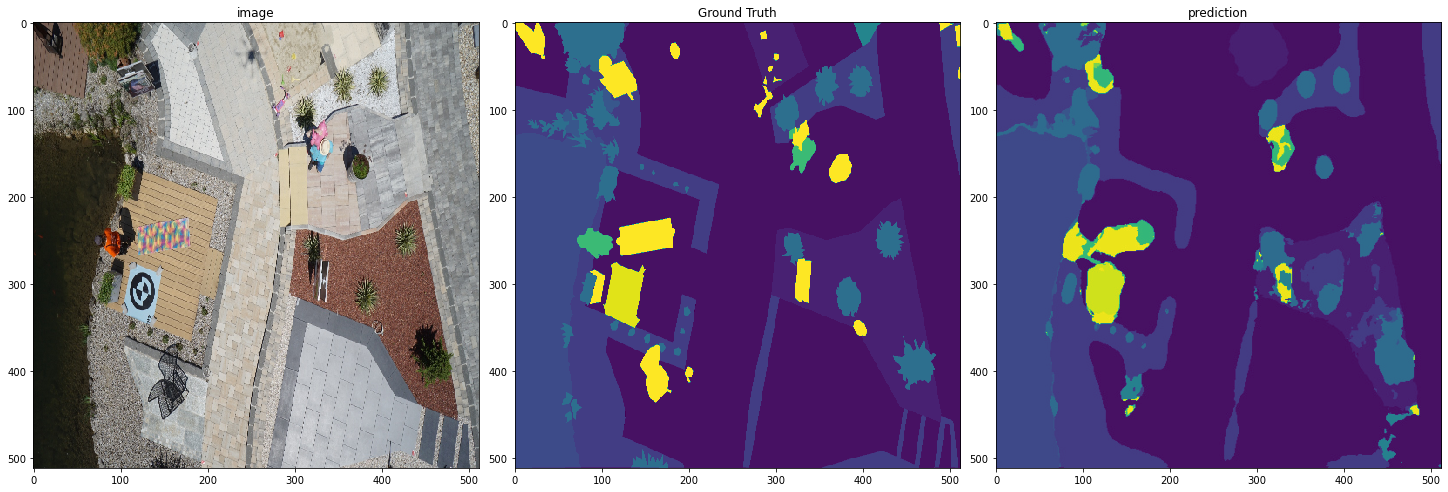

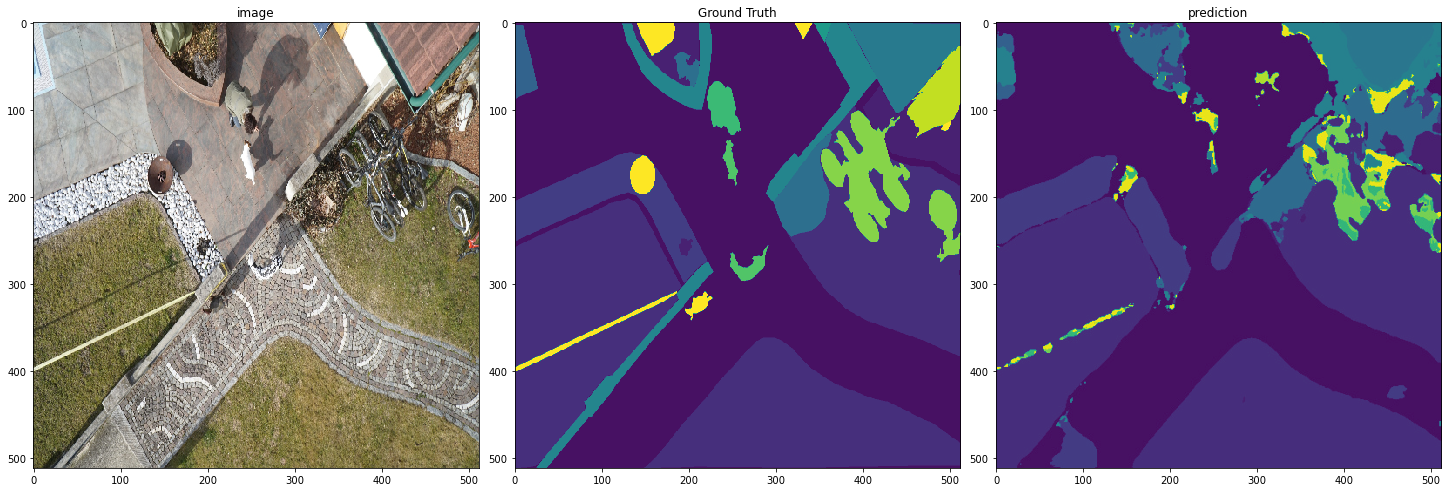

In [28]:
model = tf.keras.models.load_model('model_checkpoints/unet_plus_plus.h5')
make_predictions(model,f'{model.name}',img_test,mask_test,print_predictions=True,imgs_to_show=2)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(results.history['loss'],label='loss')
plt.plot(results.history['val_loss'],label='validation loss')
plt.title('Loss')
legend = plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('value')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Intersection over Union')
line1 = plt.plot(results.history['IoU'],label='IoU')
line2 = plt.plot(results.history['val_IoU'],label='validation IoU')
legend = plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('value')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(results.history['Cat Accuracy'],label='Accuracy')
plt.plot(results.history['val_Cat Accuracy'],label='validation Accuracy')
plt.title('Accuracy')
legend = plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('value')
plt.show()
